In [1]:
import pandas as pd
from datetime import datetime
import dateutil
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
import re
from urllib.parse import urlparse
import json

In [2]:
data = pd.read_csv('../data/in/native_ad_data.csv')

The one's from zergnet all have some newlines we need to get rid of and they appear to have concatenated the headline with the provider. So let's clean those up.

In [3]:
data['headline'] = data['headline'].apply(lambda x: re.sub('(?<=[a-z])\.?([A-Z](.*))' , '', x.strip()))
data.head()

,_id,headline,link,img,provider,source,img_file,date,final_link,orig_article
0,ObjectId(58d90ce706e10d04f7e1b3d8),20 Cool Moments From Joe Biden’s Time In Office,http://scribol.com/a/news-and-politics/ways-jo...,https://console.brax-cdn.com/creatives/98c6400...,taboola,http://tmz.com,./imgs/876aa5e83f6fb81a81908db3c02fdcc00d44400...,2017-03-27T12:59:09.279Z,http://scribol.com/a/news-and-politics/ways-jo...,NaN
1,ObjectId(58d90ce706e10d04f7e1b3d9),Troubled News Anchor Does The Unthinkable On Air,http://www.trend-chaser.com/entertainment/the-...,https://console.brax-cdn.com/creatives/b86bbc0...,taboola,http://tmz.com,./imgs/bab1037467f1385cd865c48029db808b03a151d...,2017-03-27T12:59:09.819Z,http://www.trend-chaser.com/entertainment/the-...,NaN
2,ObjectId(58d90ce706e10d04f7e1b3da),It's Almost Hard To Fathom What He look's Like...,http://www.journalistate.com/popular/big-holly...,http://cdn.taboolasyndication.com/libtrc/stati...,taboola,http://tmz.com,./imgs/feeb5be5a9758fcca8cef21b6fb842ccc839476...,2017-03-27T12:59:10.750Z,http://www.journalistate.com/popular/big-holly...,NaN
3,ObjectId(58d90ce706e10d04f7e1b3db),Troubled News Anchor Does The Unthinkable On Air,http://www.trend-chaser.com/entertainment/the-...,https://console.brax-cdn.com/creatives/b86bbc0...,taboola,http://tmz.com,./imgs/bab1037467f1385cd865c48029db808b03a151d...,2017-03-27T12:59:11.430Z,http://www.trend-chaser.com/entertainment/the-...,NaN
4,ObjectId(58d90ce706e10d04f7e1b3dc),Try NOT Gasp When You See Who Queen Latifah Is...,http://zcretuzft.iflmylife.com/entertainment/o...,http://cdn.taboolasyndication.com/libtrc/stati...,taboola,http://tmz.com,./imgs/d75401b962746864063b51f164633ffeb93931d...,2017-03-27T12:59:11.510Z,http://www.iflmylife.com/entertainment/other-h...,NaN


In [4]:
data['img_file'] = data['img_file'].apply(lambda x: re.sub('\.\/imgs\/' , '', str(x).strip()))

OK, that's better.

Do we have any null values?

In [5]:
for col in data.columns:
    print((col, sum(data[col].isnull())))

('_id', 0)
('headline', 0)
('link', 0)
('img', 0)
('provider', 0)
('source', 0)
('img_file', 0)
('date', 0)
('final_link', 0)
('orig_article', 59776)


For future reference, we have a small number of img_files that are null (probably because the scraper errored out grabbing the file). For the most part, that's pretty good.

In [6]:
data.describe()

,_id,headline,link,img,provider,source,img_file,date,final_link,orig_article
count,129399,129399,129399,129399,129399,129399,129399,129399,129399,69623
unique,129399,18022,43315,23843,4,24,23866,129396,36713,6670
top,ObjectId(58fc4a639e1e2a693fe547a6),Here’s Why Guys Are Obsessed With This Underwear…,https://grizly.com/lifestyle/guy-turned-backya...,http://cdn.taboolasyndication.com/libtrc/stati...,taboola,http://tmz.com,db07ff3401037653d665822c5a78617464fe4ef8.jpg,2017-05-30T04:48:58.234Z,https://grizly.com/lifestyle/guy-turned-backya...,http://www.tmz.com/2017/06/02/kathy-griffin-co...
freq,1,996,588,621,59474,24167,621,2,588,167


Already we can see some interesting trends here. Out of 64147 unique records, only 10260 of the headlines are unique, but 19212 of the links are unique and 12709 of the image files are unique (assuming for sure that there were issues with downloading images, but more on that later). So it seems already that there are content links which might reuse the same headline, or image for different destination articles. Let's try to dig into that.

Also, becuase we want to inspect the hosts from which the articles and images are coming from, let's parse those out in the data.

In [7]:
data['img_host'] = data['img'].apply(lambda x: urlparse(x).netloc)

In [8]:
data['link_host'] = data['final_link'].apply(lambda x: urlparse(x).netloc)

Next, let's classify each site by a very relaxed set of tags based on perceived political bias. I might be a little off on some, I referenced https://www.allsides.com/ where possible, but that was not entirely helpful in all cases. Otherwise, I just went with my own idea of where I felt a site fell on the political spectrum (e.g., left, right, or center). There is also a tag for tabloids, or primarily sites that probably don't really have an editorial perspective so much as a desire to publish whatever gets the most traffic.

In [9]:
left = ['http://www.politico.com/magazine/', 'https://www.washingtonpost.com/', 'http://www.huffingtonpost.com/', 'http://gothamist.com/news', 'http://www.metro.us/news', 'http://www.politico.com/politics', 'http://www.nydailynews.com/news', 'http://www.thedailybeast.com/']
right = ['http://www.breitbart.com', 'http://www.rt.com', 'https://nypost.com/news/', 'http://www.infowars.com/', 'https://www.therebel.media/news', 'http://observer.com/latest/']
center = ['http://www.ibtimes.com/', 'http://www.businessinsider.com/', 'http://thehill.com']
tabloid = ['http://tmz.com', 'http://www.dailymail.co.uk/', 'https://downtrend.com/', 'http://reductress.com/', 'http://preventionpulse.com/', 'http://elitedaily.com/', 'http://worldstarhiphop.com/videos/']

In [10]:
def get_classification(source):
    if source in left:
        return 'left'
    if source in right:
        return 'right'
    if source in center:
        return 'center'
    if source in tabloid:
        return 'tabloid'

In [11]:
data['source_class'] = data['source'].apply(lambda x: get_classification(x))

In [12]:
data.head()

,_id,headline,link,img,provider,source,img_file,date,final_link,orig_article,img_host,link_host,source_class
0,ObjectId(58d90ce706e10d04f7e1b3d8),20 Cool Moments From Joe Biden’s Time In Office,http://scribol.com/a/news-and-politics/ways-jo...,https://console.brax-cdn.com/creatives/98c6400...,taboola,http://tmz.com,876aa5e83f6fb81a81908db3c02fdcc00d444000.png,2017-03-27T12:59:09.279Z,http://scribol.com/a/news-and-politics/ways-jo...,NaN,console.brax-cdn.com,scribol.com,tabloid
1,ObjectId(58d90ce706e10d04f7e1b3d9),Troubled News Anchor Does The Unthinkable On Air,http://www.trend-chaser.com/entertainment/the-...,https://console.brax-cdn.com/creatives/b86bbc0...,taboola,http://tmz.com,bab1037467f1385cd865c48029db808b03a151d2.png,2017-03-27T12:59:09.819Z,http://www.trend-chaser.com/entertainment/the-...,NaN,console.brax-cdn.com,www.trend-chaser.com,tabloid
2,ObjectId(58d90ce706e10d04f7e1b3da),It's Almost Hard To Fathom What He look's Like...,http://www.journalistate.com/popular/big-holly...,http://cdn.taboolasyndication.com/libtrc/stati...,taboola,http://tmz.com,feeb5be5a9758fcca8cef21b6fb842ccc8394766.jpg,2017-03-27T12:59:10.750Z,http://www.journalistate.com/popular/big-holly...,NaN,cdn.taboolasyndication.com,www.journalistate.com,tabloid
3,ObjectId(58d90ce706e10d04f7e1b3db),Troubled News Anchor Does The Unthinkable On Air,http://www.trend-chaser.com/entertainment/the-...,https://console.brax-cdn.com/creatives/b86bbc0...,taboola,http://tmz.com,bab1037467f1385cd865c48029db808b03a151d2.png,2017-03-27T12:59:11.430Z,http://www.trend-chaser.com/entertainment/the-...,NaN,console.brax-cdn.com,www.trend-chaser.com,tabloid
4,ObjectId(58d90ce706e10d04f7e1b3dc),Try NOT Gasp When You See Who Queen Latifah Is...,http://zcretuzft.iflmylife.com/entertainment/o...,http://cdn.taboolasyndication.com/libtrc/stati...,taboola,http://tmz.com,d75401b962746864063b51f164633ffeb93931d3.jpg,2017-03-27T12:59:11.510Z,http://www.iflmylife.com/entertainment/other-h...,NaN,cdn.taboolasyndication.com,www.iflmylife.com,tabloid


In [13]:
deduped = data.drop_duplicates(subset=['headline', 'link', 'img', 'provider', 'source', 'img_file', 'final_link'], keep=False)

In [14]:
deduped.head()

,_id,headline,link,img,provider,source,img_file,date,final_link,orig_article,img_host,link_host,source_class
0,ObjectId(58d90ce706e10d04f7e1b3d8),20 Cool Moments From Joe Biden’s Time In Office,http://scribol.com/a/news-and-politics/ways-jo...,https://console.brax-cdn.com/creatives/98c6400...,taboola,http://tmz.com,876aa5e83f6fb81a81908db3c02fdcc00d444000.png,2017-03-27T12:59:09.279Z,http://scribol.com/a/news-and-politics/ways-jo...,NaN,console.brax-cdn.com,scribol.com,tabloid
8,ObjectId(58d90ce706e10d04f7e1b3e0),25 Pics Donald Trump Doesn't Want You To See,http://adrzr.com/54f7?utm_source=8b4&utm_campa...,http://cdn.taboolasyndication.com/libtrc/stati...,taboola,http://tmz.com,d3a3f2f50c84529c08bb8314ae3aa66280f0cbc7.png,2017-03-27T12:59:13.038Z,http://detonate.com/pictures-that-trump-would-...,NaN,cdn.taboolasyndication.com,detonate.com,tabloid
10,ObjectId(58d90ce706e10d04f7e1b3e2),Do This Tonight to Make Fungus Disappear by Mo...,http://japanesetoenailfunguscode.com/?aff_id=4...,https://revcontent-p0.s3.amazonaws.com/content...,revcontent,http://worldstarhiphop.com/videos/,e2bb63d58e09bae569a90f64de24c93a2d008e34.jpg,2017-03-27T12:59:15.114Z,http://japanesetoenailfunguscode.com/?aff_id=4...,NaN,revcontent-p0.s3.amazonaws.com,japanesetoenailfunguscode.com,tabloid
11,ObjectId(58d90ce706e10d04f7e1b3e3),Here's What New Dental Implants Should Cost Yo...,http://gaindentalfixdeals.com/?affid=1016&s1=1...,https://revcontent-p0.s3.amazonaws.com/content...,revcontent,http://worldstarhiphop.com/videos/,f70f91d2ebf37e35480fe4f689477406adf9243e.jpg,2017-03-27T12:59:15.237Z,http://gaindentalfixdeals.com/?affid=1016&s1=1...,NaN,revcontent-p0.s3.amazonaws.com,gaindentalfixdeals.com,tabloid
12,ObjectId(58d90ce706e10d04f7e1b3e4),Michael Jordan Has Pretty Much Given Up on His...,http://trends.revcontent.com/click.php?d=vJdwp...,https://revcontent-p0.s3.amazonaws.com/content...,revcontent,http://worldstarhiphop.com/videos/,ab914b86682795c6d6624707b22b06f88f0e551a.jpg,2017-03-27T12:59:15.614Z,http://trends.revcontent.com/click.php?d=vJdwp...,NaN,revcontent-p0.s3.amazonaws.com,trends.revcontent.com,tabloid


And let's just check on those null values again...

In [15]:
for col in deduped.columns:
    print((col, sum(deduped[col].isnull())))

('_id', 0)
('headline', 0)
('link', 0)
('img', 0)
('provider', 0)
('source', 0)
('img_file', 0)
('date', 0)
('final_link', 0)
('orig_article', 18453)
('img_host', 0)
('link_host', 0)
('source_class', 0)


But that's enough of that. Let's return to the unique records we're interested in in `deduped`. But first, let's take a look at the rate of success for our record collection.

In [16]:
(43630/129399)*100

33.71741667246269

Crud, doing a harvest yields results where only 33% of our sample is worth examining further. 

Note: We might still be interested in the duplicates if we take a look at the distribution of those records over time. Below, we should probably reduce the date of collection to a week or maybe a 3 day sequence and only remove duplicates if they happened within that period. Which might tell us something about content being shuffled in and out by the provider.

Let's get the top 10 headlines grouped by img

In [17]:
deduped['headline'].groupby(deduped['img']).value_counts().nlargest(10)

img                                                                                                         headline                                                                                                 
http://cdn.taboolasyndication.com/libtrc/static/thumbnails/21a99ebd78f2af61aeeec2074e0376c0.jpg             Nicole Kidman's Yacht Is Far From You'd Expect                                                               368
https://revcontent-p0.s3.amazonaws.com/content/images/1495720487.jpg                                        Triple Your Accuracy With This Weird Shooting Technique Used By Seal Snipers                                 238
http://cdn.taboolasyndication.com/libtrc/static/thumbnails/0dba2430aca9e98e05160cfd6e6d3171.jpg             Here Is How You Upgrade To Business Class                                                                    227
http://cdn.taboolasyndication.com/libtrc/static/thumbnails/2e967b6db0813815a899401b4746a749.jpg             Stairlifts are 

But hang on. let's just see what the top headlines are. There's certainly overlap, but it's not a one to one relationship between headlines and their images (or at least maybe it's the same image, but coming from a different URL).

In [18]:
deduped['headline'].value_counts().nlargest(10)

Nicole Kidman's Yacht Is Far From You'd Expect                                                               376
Triple Your Accuracy With This Weird Shooting Technique Used By Seal Snipers                                 260
Forget Social Security if you Own a Home (Do This)                                                           231
Here Is How You Upgrade To Business Class                                                                    227
Stairlifts are disrupting the multi-billion dollar retirement home industry - keeping seniors independent    200
Tiger Woods' Yacht Is Far From You'd Expect                                                                  181
Watch Obama's Face at 0:33. This Leaked Video Will Destroy Obama's Legacy                                    169
New Jersey Landlines Get Replaced (But Not With Cell Phones)                                                 161
Best Senior Living Communities Of 2017! View Pricing Here & Compare                             

Note: perhaps something we will want to look into is how many different headline, image permutations there are. I am particularly interested in the reuse of images across different headlines.

In [19]:
deduped['source'].value_counts().nlargest(25)

http://tmz.com                        5070
http://elitedaily.com/                4873
http://www.politico.com/magazine/     3151
https://www.washingtonpost.com/       2961
http://www.infowars.com/              2561
http://www.thedailybeast.com/         2455
http://www.breitbart.com              2443
https://downtrend.com/                2421
http://www.ibtimes.com/               2323
http://thehill.com                    2001
http://www.businessinsider.com/       1984
http://www.rt.com                     1819
http://www.politico.com/politics      1708
http://worldstarhiphop.com/videos/    1292
http://www.dailymail.co.uk/           1159
http://reductress.com/                1082
https://nypost.com/news/               979
http://www.nydailynews.com/news        864
http://www.huffingtonpost.com/         814
https://www.therebel.media/news        756
http://observer.com/latest/            696
http://preventionpulse.com/            108
http://gothamist.com/news               74
http://www.

And what about by classification

In [20]:
deduped['source_class'].value_counts()

tabloid    16005
left       12063
right       9254
center      6308
Name: source_class, dtype: int64

In [21]:
deduped.groupby(['provider', 'source_class'])['source'].value_counts()

provider    source_class  source                            
outbrain    center        http://thehill.com                    2001
            left          http://www.politico.com/magazine/     3151
                          https://www.washingtonpost.com/       2961
                          http://www.thedailybeast.com/         2455
            right         https://nypost.com/news/               979
                          http://observer.com/latest/            696
revcontent  center        http://www.ibtimes.com/               2323
            left          http://www.metro.us/news                36
            right         http://www.infowars.com/              2561
            tabloid       https://downtrend.com/                2421
                          http://worldstarhiphop.com/videos/    1292
                          http://preventionpulse.com/            108
taboola     center        http://www.businessinsider.com/       1984
            left          http://www.polit

ok so what are the most frequent images?

In [22]:
IMG_MAX=5

In [23]:
topimgs_center = deduped['img'][deduped['source_class'].isin(['center'])].value_counts().nlargest(IMG_MAX).index.tolist()

In [24]:
topimgs_left = deduped['img'][deduped['source_class'].isin(['left'])].value_counts().nlargest(IMG_MAX).index.tolist()

In [25]:
topimgs_right = deduped['img'][deduped['source_class'].isin(['right'])].value_counts().nlargest(IMG_MAX).index.tolist()

In [26]:
topimgs_tabloid = deduped['img'][deduped['source_class'].isin(['tabloid'])].value_counts().nlargest(IMG_MAX).index.tolist()

In [27]:
for i in topimgs_center:
    displaystring = '<img src={} width="200"/>'.format(i)
    display(HTML(displaystring))

In [28]:
for i in topimgs_left:
    displaystring = '<img src={} width="200"/>'.format(i)
    display(HTML(displaystring))

In [29]:
for i in topimgs_right:
    displaystring = '<img src={} width="200"/>'.format(i)
    display(HTML(displaystring))

In [30]:
for i in topimgs_tabloid:
    displaystring = '<img src={} width="200"/>'.format(i)
    display(HTML(displaystring))

Yawn!!

In [31]:
deduped['link_host'].value_counts().nlargest(25)

www.zergnet.com              7257
trends.revcontent.com        6658
www.tmz.com                  1309
loanpride.com                 925
thehill.com                   674
www.historyinorbit.com        504
www.yimgl.com                 478
www.talktechdaily.com         477
scribol.com                   460
www.nextadvisor.com           438
morningfinance.com            368
search.yahoo.com              288
www.lifedaily.com             270
www.trend-chaser.com          267
thebetterfinance.com          265
www.directexpose.com          258
weightlossgroove.com          241
definition.org                240
beairfareok.live              227
www.aarp.org                  217
www.justjared.com             209
www.thebrofessional.net       197
frank151.com                  196
postpopular.com               186
quizzes.howstuffworks.com     183
Name: link_host, dtype: int64

In [32]:
deduped['img_host'].value_counts().nlargest(25)

images.outbrain.com                          12259
revcontent-p0.s3.amazonaws.com                8554
cdn.taboolasyndication.com                    7310
img4.zergnet.com                              2121
img1.zergnet.com                              2037
img5.zergnet.com                              2015
img2.zergnet.com                              1948
console.brax-cdn.com                          1837
d2x3bkdslnxkuj.cloudfront.net                 1094
cdn.taboola.com                                473
prezna.com                                     332
www.talktechdaily.com                          289
www.consumerdaily.com                          201
revcontent-production.s3.amazonaws.com         191
gleaned-images.stuff.com                       188
11001100.s3.amazonaws.com                      176
s3.amazonaws.com                               176
b1.spassets.com                                151
prod-cm-minder-uploads.s3.amazonaws.com        123
eam.hexagram.com               

In [33]:
deduped_date_idx = deduped.copy(deep=False)

In [34]:
deduped_date_idx['date'] = pd.to_datetime(deduped_date_idx.date)

In [35]:
deduped_date_idx.set_index('date',inplace=True)

See what dates we're working with

In [36]:
"Start: {}  -  End: {}".format(deduped_date_idx.index.min(), deduped_date_idx.index.max())

'Start: 2017-03-27 12:59:09.279000  -  End: 2017-07-09 14:31:09.853000'

In [37]:
deduped_date_idx['2017-07-01':'2017-07-07'].describe()

,_id,headline,link,img,provider,source,img_file,final_link,orig_article,img_host,link_host,source_class
count,4740,4740,4740,4740,4740,4740,4740,4740,4740,4740,4740,4740
unique,4740,2030,4339,2247,4,20,2256,4054,892,123,575,4
top,ObjectId(5957971006e10d07406c1df8),Triple Your Accuracy With This Weird Shooting ...,http://nmaio.primaltraffic.com/3b3f0b9d-b2a3-4...,https://revcontent-p0.s3.amazonaws.com/content...,revcontent,https://downtrend.com/,1e3bc2adc7eba5d0f29fff42ff8ab0a55853f1aa.jpg,http://www.zergnet.com/news/1707646/what-men-f...,http://www.businessinsider.com/dave-mcclure-no...,revcontent-p0.s3.amazonaws.com,trends.revcontent.com,tabloid
freq,1,90,34,90,1650,495,90,15,43,1619,1650,1618


In [38]:
deduped_date_idx['2017-03-27':'2017-07-07'].groupby('source_class').resample('M').size().plot(kind='bar')

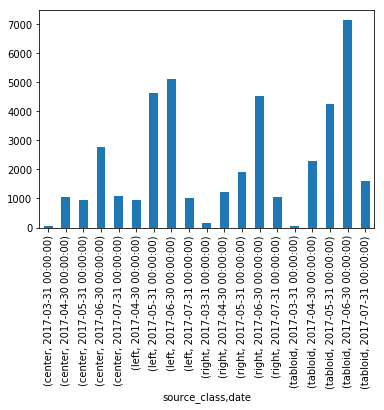

In [39]:
plt.show()

In [40]:
deduped_date_idx['2017-06-01':'2017-06-30'].groupby('source').resample('M').size().plot(kind='bar')

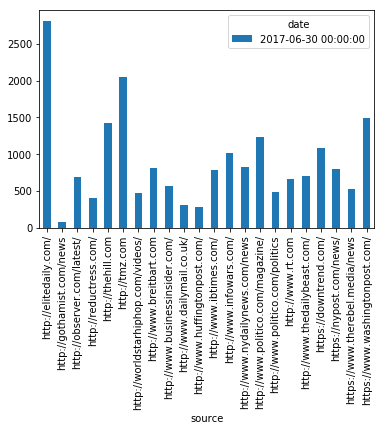

In [41]:
plt.show()

In [42]:
(deduped_date_idx['2017-03-27':'2017-07-07'])['headline'].value_counts().nlargest(10)

Nicole Kidman's Yacht Is Far From You'd Expect                                                               348
Triple Your Accuracy With This Weird Shooting Technique Used By Seal Snipers                                 230
Here Is How You Upgrade To Business Class                                                                    227
Forget Social Security if you Own a Home (Do This)                                                           224
Stairlifts are disrupting the multi-billion dollar retirement home industry - keeping seniors independent    194
Tiger Woods' Yacht Is Far From You'd Expect                                                                  179
Watch Obama's Face at 0:33. This Leaked Video Will Destroy Obama's Legacy                                    164
New Jersey Landlines Get Replaced (But Not With Cell Phones)                                                 161
Best Senior Living Communities Of 2017! View Pricing Here & Compare                             

In [43]:
deduped['headline'][deduped['source_class'].isin(['center'])].value_counts().nlargest(10)

27 Stars Who Died And Not a Word Was Said              91
Men, Eliminate Your ED (Do This Once Daily)            90
21 Celebrities Who Died And Not a Word Was Said        90
Remember Hurley? What He Looks Like Today Is Unreal    75
She Never Mentions Her Other Daughter, Here's Why      74
Here Is How You Upgrade To Business Class              70
Celebs Who Died And No One Said A Word                 68
How to Fix Cracked Feet                                67
Forget Social Security if you Own a Home (Do This)     63
He Never Mentions His Daughter - Here Is Why           52
Name: headline, dtype: int64

In [44]:
deduped['headline'][deduped['source_class'].isin(['left'])].value_counts().nlargest(10)

Stairlifts are disrupting the multi-billion dollar retirement home industry - keeping seniors independent    173
Forget Social Security if you Own a Home (Do This)                                                           168
Here Is How You Upgrade To Business Class                                                                    157
Best Senior Living Communities Of 2017! View Pricing Here & Compare                                          109
Forget Social Security if you Own a Home (Do…                                                                 83
Thinking About Installing Solar Panels? Read This First                                                       65
Eddie Murphy's House Is Far From What You'd Expect                                                            63
The Most Common Cancer Symptoms People Ignore                                                                 55
Forget Social Security if you Own a Home…                                                       

In [45]:
deduped['headline'][deduped['source_class'].isin(['right'])].value_counts().nlargest(10)

Nicole Kidman's Yacht Is Far From You'd Expect                                  365
Tiger Woods' Yacht Is Far From You'd Expect                                     140
Watch Obama's Face at 0:33. This Leaked Video Will Destroy Obama's Legacy       138
We Can Guess Your Education Level with Only 10 Questions                        132
Triple Your Accuracy With This Weird Shooting Technique Used By Seal Snipers    123
Born Before 1969? You Could Get an Extra $2,194 Monthly with This               105
Goldman Sachs & World Bank Confirm: Us Dollar Will Be Worthless in 100 Days     103
Search For The Best New Pickup Truck                                             92
Hemp Company Releases Legal CBD Oil Across All 50 States                         83
This Is The Shopping Site Amazon Doesn't Want You To Know About                  75
Name: headline, dtype: int64

In [46]:
deduped['headline'][deduped['source_class'].isin(['tabloid'])].value_counts().nlargest(10)

28 Pictures That Show How Crazy Woodstock 1969 Was                              139
Triple Your Accuracy With This Weird Shooting Technique Used By Seal Snipers    137
Kim Kardashian and North West Turn Heads On The Red Carpet                      126
Trump Voters Shocked After Watching This Leaked Video                           125
10 Surprising Things Guys Find Unattractive                                     114
What Tiger Woods' Ex-Wife Looks Like Now Left Us With No Words                  100
9 Hair Mistakes That Make You Look Older                                        100
10 Features That Attract Men The Most                                            97
After Losing 220lbs Rebel Wilson Is Gorgeous Now!                                96
10 Tricks To Always Look Good In Pictures                                        95
Name: headline, dtype: int64

Let's take a look at the images for the headline about dead celebrities, are they all the same?

In [47]:
def imgs_from_headlines(headline):
    """
    A function to spit out all the different images used for a headline, assuming there's no more than 50/headline
    """
    all_images_dead_celeb = deduped['img'][deduped['headline'].isin([headline])].value_counts().nlargest(50).index.tolist()
    for i in all_images_dead_celeb:
        displaystring = '<img src={} width="200"/>'.format(i)
        display(HTML(displaystring))

In [63]:
imgs_from_headlines("28 Pictures That Show How Crazy Woodstock 1969 Was")

In [49]:
timestamp = datetime.now().strftime('%Y-%m-%d-%H_%M')

In [50]:
datefile = '../data/out/{}_native_ad_data_deduped.csv'.format(timestamp)

In [51]:
deduped.to_csv(datefile, index=False)

Finally, let's generate a json file where each item is an individual image, and for each image we are listing out all the original sources, dates, headlines, classifications, and final locations for it. 

In [52]:
img_json_data = {}
for index, row in deduped.iterrows():
    img_json_data[row['img_file']] = {'url':row['img'],
                                 'dates':[],
                                 'sources':[],
                                 'providers':[],
                                 'classifications':[],
                                 'headlines':[],
                                 'locations':[],
                                 }

In [53]:
print(len(img_json_data.keys()))

19314


In [54]:
for index, row in deduped.iterrows():
    record = img_json_data[row['img_file']]
    if row['date'] not in record['dates']:  
        record['dates'].append(row['date'])
    if row['headline'] not in record['headlines']:
        record['headlines'].append(row['headline'])
    if row['provider'] not in record['providers']:
        record['providers'].append(row['provider'])
    if row['source_class'] not in record['classifications']:
        record['classifications'].append(row['source_class'])
    if row['source'] not in record['sources']:
        record['sources'].append(row['source'])
    if row['final_link'] not in record['locations']:    
        record['locations'].append(row['final_link'])

In [55]:
for i in list(img_json_data.keys())[0:5]:
    print(img_json_data[i])

{'url': 'https://console.brax-cdn.com/creatives/98c6400e-f2fc-4c28-8e00-6c45914e36d5/TB15_1b309a68a23702cb95e743cea5d60029.600x500.png', 'dates': ['2017-03-27T12:59:09.279Z'], 'sources': ['http://tmz.com'], 'providers': ['taboola'], 'classifications': ['tabloid'], 'headlines': ['20 Cool Moments From Joe Biden’s Time In Office'], 'locations': ['http://scribol.com/a/news-and-politics/ways-joe-biden-made-vice-presidency-cool-again-americas-uncle/?utm_source=Taboola&utm_medium=CPC&utm_campaign=Joe_Biden_Cool_VP_US_Desktop&utm_content=tmz']}
{'url': 'http://cdn.taboolasyndication.com/libtrc/static/thumbnails/b13e719e4aff1daf7284c9bdb61e65a1.png', 'dates': ['2017-03-27T12:59:13.038Z'], 'sources': ['http://tmz.com'], 'providers': ['taboola'], 'classifications': ['tabloid'], 'headlines': ["25 Pics Donald Trump Doesn't Want You To See"], 'locations': ['http://detonate.com/pictures-that-trump-would-rather-keep-secret/?utm_source=8b4&utm_campaign=8b4_US_desktop_Trump_12_54f7_20160725_mm_3407&utm_

In [56]:
hl_json_data = {}
for index, row in deduped.iterrows():
    hl_json_data[row['headline']] = {'img_urls':[],
                                 'dates':[],
                                 'sources':[],
                                 'providers':[],
                                 'classifications':[],
                                 'imgs':[],
                                 'locations':[],
                                 }

In [57]:
print(len(hl_json_data.keys()))

15219


In [58]:
for index, row in deduped.iterrows():
    record = hl_json_data[row['headline']]
    if row['img'] not in record['img_urls']:
        record['img_urls'].append(row['img'])
    if row['date'] not in record['dates']:  
        record['dates'].append(row['date'])
    if row['img_file'] not in record['imgs']:
        record['imgs'].append(row['img_file'])
    if row['provider'] not in record['providers']:
        record['providers'].append(row['provider'])
    if row['source_class'] not in record['classifications']:
        record['classifications'].append(row['source_class'])
    if row['source'] not in record['sources']:
        record['sources'].append(row['source'])
    if row['final_link'] not in record['locations']:    
        record['locations'].append(row['final_link'])

In [59]:
for i in list(hl_json_data.keys())[0:5]:
    print(i, " = " ,hl_json_data[i])

20 Cool Moments From Joe Biden’s Time In Office  =  {'img_urls': ['https://console.brax-cdn.com/creatives/98c6400e-f2fc-4c28-8e00-6c45914e36d5/TB15_1b309a68a23702cb95e743cea5d60029.600x500.png'], 'dates': ['2017-03-27T12:59:09.279Z'], 'sources': ['http://tmz.com'], 'providers': ['taboola'], 'classifications': ['tabloid'], 'imgs': ['876aa5e83f6fb81a81908db3c02fdcc00d444000.png'], 'locations': ['http://scribol.com/a/news-and-politics/ways-joe-biden-made-vice-presidency-cool-again-americas-uncle/?utm_source=Taboola&utm_medium=CPC&utm_campaign=Joe_Biden_Cool_VP_US_Desktop&utm_content=tmz']}
25 Pics Donald Trump Doesn't Want You To See  =  {'img_urls': ['http://cdn.taboolasyndication.com/libtrc/static/thumbnails/b13e719e4aff1daf7284c9bdb61e65a1.png'], 'dates': ['2017-03-27T12:59:13.038Z'], 'sources': ['http://tmz.com'], 'providers': ['taboola'], 'classifications': ['tabloid'], 'imgs': ['d3a3f2f50c84529c08bb8314ae3aa66280f0cbc7.png'], 'locations': ['http://detonate.com/pictures-that-trump-wo

In [60]:
def to_json_file(json_data, prefix):
    filename = "../data/out/{}_grouped_data.json".format(prefix)
    with open(filename, 'w') as outfile:
        json.dump(json_data, outfile, indent=4)

In [61]:
to_json_file(img_json_data, "images")

In [62]:
to_json_file(hl_json_data, "headlines")